# Connectivity and sensitivity analysis at scale

This notebook demonstrates how to quantify ecological connectivity and perform sensitivity analysis over large landscapes, leveraging moving windows to accelerate computations using the `ConnectivityAnalysis` and `SensitivityAnalysis` utilities.

### Prerequisites
```bash
pip install jaxscape rasterio matplotlib
```

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib
import rasterio

from jaxscape import LCPDistance, ConnectivityAnalysis, SensitivityAnalysis

## Load data

We load a habitat "suitability" raster (typically the output of a species distribution model), and confound it with the permeability raster. We also use it to weight the importance of each site when calculating connectivity (see thereafter). In practice, you may want to use different rasters for these purposes.

The raster values are normalized to [0, 1] range, with 0 representing unsuitable habitat and 1 representing optimal conditions.

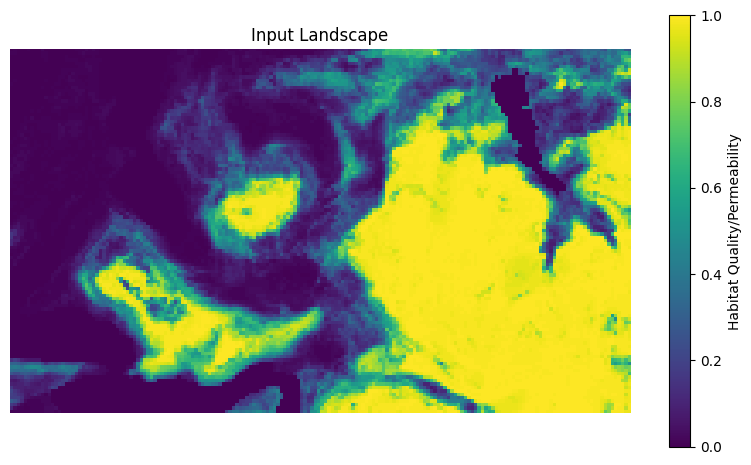

In [2]:
# Load habitat suitability raster
with rasterio.open("../data/suitability.tif") as src:
    raster = src.read(1, masked=True)  # Read first band with masking
    quality_raster = jnp.array(raster.filled(0), dtype="float32") / 100  # Normalize to [0, 1]

# Visualize the landscape
plt.figure(figsize=(10, 8))
plt.imshow(quality_raster, cmap='viridis')
plt.colorbar(label='Habitat Quality/Permeability', shrink=0.7)
plt.title('Input Landscape')
plt.axis('off')
plt.show()

## Define dispersal parameters for the target species

We need to specify:

- **Dispersal range (D)**: maximum distance an individual can traverse (in pixels) through optimal habitat (permeability = 1)
- **Distance metric**
- **Proximity function**: how distance translates to a certain probability of dispersal

Common proximity functions are
- **Negative exponential**: `exp(-d/D)` for smooth decay (used here)
- **Threshold**: `(d < D).astype(float)` for binary connectivity
- **Power law**: `d**(-α)` for fat-tailed dispersal

In [3]:
# Define dispersal range (in pixels; you'd need to convert from real units based on raster resolution)
D = 20  # Maximum dispersal distance through optimal habitat

distance = LCPDistance() 

# Define proximity function: converts distance to probability of dispersal
def proximity(dist):
    """Negative exponential decay of connectivity with distance."""
    return jnp.exp(-dist / D)

## Calculate landscape connectivity

`ConnectivityAnalysis` computes the overall landscape connectivity by summing quality-weighted proximities between all pairs of habitat cells. This produces a scalar measure of total connectivity.

**Key parameters:**
- `quality_raster`: Habitat quality or patch importance
- `permeability_raster`: Movement cost surface
- `distance`: Distance metric (LCP, Resistance, or RSP)
- `proximity`: Function converting distance to connectivity
- `dependency_range`: Maximum relevant distance (optimization parameter)
- `batch_size`: Parallel processing batch size (tune based on available memory)
- `q_weighted`: Whether to weight by quality (`True`) or not (`False`)

In [4]:
# Initialize connectivity analysis
connectivity_prob = ConnectivityAnalysis(
    quality_raster=quality_raster,
    permeability_raster=quality_raster,
    distance=distance,
    proximity=proximity,
    dependency_range=D,
    batch_size=50  # Process 50 cells per batch
)

# Compute baseline connectivity (unweighted by quality)
connectivity = connectivity_prob.run(q_weighted=False)
print(f"Baseline landscape connectivity: {connectivity:.0f}")

Batch progress: 100%|██████████| 6/6 [03:22<00:00, 33.77s/it]

Baseline landscape connectivity: 3843799


!!! tip "Coarsening factor"
    You can specify a `coarsening_factor` to aggregate the raster spatially, reducing resolution to speed up computations. A value of 0.0 means no aggregation, while higher values increase aggregation. This is an experimental feature and may affect accuracy.

## Sensitivity analysis

`SensitivityAnalysis` computes the derivative of `ConnectivityAnalysis` with respect to either permeability or quality. This allows identifying which landscape cells, when improved, would most increase overall connectivity.

The output is a raster where each cell value represents the marginal effect of improving that cell on total connectivity.

In [5]:
# Initialize sensitivity analysis
sensitivity_prob = SensitivityAnalysis(
    quality_raster=quality_raster,
    permeability_raster=quality_raster,
    distance=distance,
    proximity=proximity,
    dependency_range=D,
    batch_size=20  # Smaller batch size for memory efficiency
)

# Compute sensitivity with respect to permeability
sensitivity_permeability = sensitivity_prob.run("permeability", q_weighted=True)
print(f"Sensitivity raster computed with shape: {sensitivity_permeability.shape}")

Batch progress: 100%|██████████| 32/32 [08:18<00:00, 15.57s/it]

Sensitivity raster computed with shape: (107, 182)


It is usually advised to convert sensitivity to **elasticity**, which express the proportional change in connectivity from a proportional change in permeability. This is computed as:

$$\text{Elasticity} = \frac{\partial C}{\partial p} \times p$$

where $C$ is the ecological connectivity and $p$ is permeability.

Elasticity is more interpretable than raw sensitivity because it's scale-independent and represents percent change in connectivity per percent change in permeability.

**High elasticity areas** are the most impactful for conservation - small improvements there yield large connectivity gains.

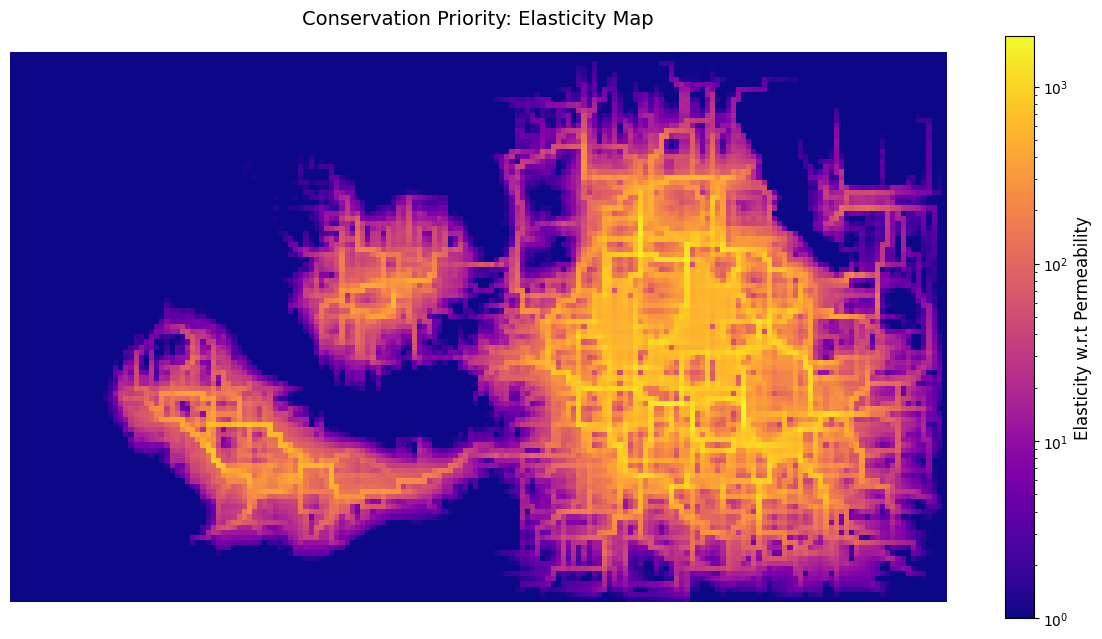

High elasticity areas (bright colors) have the greatest conservation impact!


In [6]:
# Compute elasticity: sensitivity × current permeability
elasticity = sensitivity_permeability * quality_raster
elasticity = jnp.nan_to_num(elasticity, nan=0.0)  # Replace NaN with 0

# Visualize elasticity on log scale (highlights variation)
plt.figure(figsize=(12, 10))
plt.imshow(
    elasticity + 1e-2,  # Add small constant for log scale
    cmap='plasma',
    norm=matplotlib.colors.LogNorm(vmin=1e0)
)
plt.axis('off')
cbar = plt.colorbar(shrink=0.6)
cbar.set_label('Elasticity w.r.t Permeability', fontsize=12)
plt.title('Conservation Priority: Elasticity Map', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('elasticity_permeability.png', dpi=300, bbox_inches='tight')
plt.show()

print("High elasticity areas (bright colors) have the greatest conservation impact!")

## Conservation prioritization: comparing strategies

We now compare two prioritization strategies for habitat restoration, to demonstrate the practical value of sensitivity analysis:

1. **Elasticity-based**: Target the top 5% of cells by elasticity
2. **Random**: Target random cells (control)

For each strategy, we simulate improving permeability by 0.4 units (40% of the scale) and measure the resulting gain in landscape connectivity.

In [7]:
# Define improvement magnitude
improved_permeability = 0.4  # Permeability increase per restored cell

# Strategy 1: Target high elasticity cells (top 5%)
threshold = jnp.percentile(elasticity, 95)  # 95th percentile
high_sensitivity_coords = jnp.where(elasticity >= threshold)
improved_quality_raster = quality_raster.at[high_sensitivity_coords].add(improved_permeability)

print(f"Strategy 1: Restoring {high_sensitivity_coords[0].size} cells based on elasticity")

# Strategy 2: Target random cells (same number as Strategy 1)
key = jr.PRNGKey(0)
random_indices = jr.choice(
    key,
    jnp.arange(elasticity.size),
    shape=(high_sensitivity_coords[0].size,),
    replace=False
)
random_coords = jnp.unravel_index(random_indices, quality_raster.shape)
modified_quality_raster = quality_raster.at[random_coords].add(improved_permeability)

print(f"Strategy 2: Restoring {random_coords[0].size} random cells (control)")

Strategy 1: Restoring 974 cells based on elasticity
Strategy 2: Restoring 974 random cells (control)


We now compute landscape connectivity for:
1. Baseline (no restoration)
2. Elasticity-based restoration
3. Random restoration

The connectivity gain is expressed as a percentage increase over baseline.

In [8]:
def run_connectivity_analysis(raster):
    """Helper function to compute connectivity for a given permeability raster."""
    connectivity_prob = ConnectivityAnalysis(
        quality_raster=quality_raster,
        permeability_raster=raster,
        distance=distance,
        proximity=proximity,
        coarsening_factor=0.,
        dependency_range=D,
        batch_size=50
    )
    return connectivity_prob.run(q_weighted=True)

# Compute connectivity for all scenarios
print("Computing connectivity for baseline...")
base_connectivity = run_connectivity_analysis(quality_raster)

print("Computing connectivity for elasticity-based restoration...")
connectivity_improved = run_connectivity_analysis(improved_quality_raster)

print("Computing connectivity for random restoration...")
connectivity_improved_randomly = run_connectivity_analysis(modified_quality_raster)

Computing connectivity for baseline...


Batch progress:  83%|████████▎ | 5/6 [02:58<00:35, 35.68s/it]


KeyboardInterrupt: 

The results demonstrate the advantage of using elasticity-based prioritization over random selection. By targeting high-elasticity areas, we achieve greater connectivity gains with the same restoration budget.

In [ ]:
# Calculate percent gains
elasticity_gain = (connectivity_improved - base_connectivity) / base_connectivity * 100
random_gain = (connectivity_improved_randomly - base_connectivity) / base_connectivity * 100

print("="*60)
print("LANDSCAPE CONNECTIVITY GAIN")
print("="*60)
print(f"Baseline connectivity:           {base_connectivity:.2f}")
print(f"\nElasticity-based restoration:    {connectivity_improved:.2f} (+{elasticity_gain:.2f}%)")
print(f"Random restoration (control):    {connectivity_improved_randomly:.2f} (+{random_gain:.2f}%)")
print(f"\nElasticity advantage:            {elasticity_gain / random_gain:.2f}x more effective")
print("="*60)

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 6))
strategies = ['Baseline', 'Elasticity-based', 'Random']
connectivities = [base_connectivity, connectivity_improved, connectivity_improved_randomly]
colors = ['gray', 'green', 'orange']

bars = ax.bar(strategies, connectivities, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Landscape Connectivity', fontsize=12)
ax.set_title('Restoration Strategy Comparison', fontsize=14, pad=20)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, connectivities)):
    if i > 0:
        gain = (val - base_connectivity) / base_connectivity * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'+{gain:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Elasticity-based prioritization significantly outperforms random selection!")

## Key Takeaways

This notebook demonstrated how **sensitivity analysis** identifies landscape modifications with the greatest connectivity impact. By converting raw sensitivity to **elasticity** (a scale-independent measure), we can prioritize restoration sites objectively. The results show that elasticity-based targeting substantially outperforms random selection, achieving greater connectivity gains with the same restoration budget.

JAXScape's automatic differentiation through JAX enables efficient computation of these gradient-based metrics at landscape scale. The framework is highly flexible: you can substitute different distance metrics (LCP, Resistance, RSP), proximity functions (exponential, threshold, power law), dispersal parameters, or conservation objectives (quality enhancement versus permeability improvement) to match your species and management scenarios. You may also implement your own definition of ecological connectivity; see [Advanced topics](vboussange.github.io/jaxscape/docs/advanced/moving_windows/).